In [1]:
import regex
import matplotlib.pyplot as plt

from pathlib import Path

In [2]:
def find_matches(pattern: str, limit: int = None):
    out = {}
    for ustawa in list(Path("./ustawy/").iterdir())[:limit]:
        matches = regex.findall(pattern=pattern, string=ustawa.read_text(encoding="utf8"))
        out[ustawa.name] = matches
    return out

def count_matches(pattern: str, limit: int = None):
    out = {}
    for ustawa in list(Path("./ustawy/").iterdir())[:limit]:
        matches = regex.findall(pattern=pattern, string=ustawa.read_text(encoding="utf8"))
        out[ustawa.name] = len(matches)
    return out

In [43]:
# Przydatny regex, dopasowujący wystąpienie jednostki redakcyjnej 
# artykuł, paragraf, ustęp, punkt, litera
# wraz z zakresem (np. art. 1-3)
# grupy są non-capturing, żeby regex nie zwracał krotek
# dodany modyfikator case-insensitive

jedn_regex = r"(?i)(?:art\. \d+\w*(?:-\d+\w*)*|§ \d+(?:-\d+)*|ust\. \d+\w*(?:-\d+\w*)*|pkt \d+\w*(?:-\d+\w*)*|lit\.\w+\)(?:-\w+\))*)"

find_matches(jedn_regex, 1)["1993_599.txt"][33:43]

['ust. 2a',
 'ust. 2',
 'ust. 3',
 'ust. 1',
 'art. 14',
 'art. 7',
 'ust. 1',
 'art. 47',
 'art. 21',
 'pkt 2-4']

### 1. Dla każdej ustawy policz wszystkie wystąpienie następujących nowelizacji:

#### a. dodanie jednostki (e.g. dodaje się ust. 5a)

Struktura:
- na początku dodania występuje równoważnik zdania zawierający synonim "dodaje się" (składa się z liter, liczb, kropek, spacji, § - bo mogą być wypisane jednostki redakcyjne),
- następnie określona jest dodawana jednostka redakcyjna (lub jednostki),
- na końcu występuje "w brzmieniu:".

In [44]:
r1a = fr"(?i)[\w\d\.§ ]+{jedn_regex}(?: i {jedn_regex}| i \d+\w*)? w brzmieniu:"

find_matches(pattern=r1a, limit=2)

{'1993_599.txt': [' dodaje się ust. 2 w brzmieniu:',
  ' po ust. 8 dodaje się ust. 8a w brzmieniu:',
  ' po ust. 5 dodaje się ust. 5a w brzmieniu:',
  ' po ust. 2 dodaje się ust. 2a w brzmieniu:',
  ' w art. 20 po ust. 3 dodaje się ust. 4 i 5 w brzmieniu:',
  ' po pkt 3 dodaje się pkt 4 w brzmieniu:',
  ' po ust. 3 dodaje się ust. 4 w brzmieniu:',
  ' dodaje się ust. 5 w brzmieniu:',
  ' po pkt 3 dodaje się pkt 4 i 5 w brzmieniu:',
  ' dodaje się ust. 3 w brzmieniu:'],
 '1993_602.txt': [' po ust. 3a dodaje się ust. 3b i 3c w brzmieniu:']}

#### b. usunięcie jednostki (np. w art. 10 ust. 1 pkt 8 skreśla się)

Struktura:
- w skreśleniu występuje "skreśla się",
- następnie występuje usuwana jednostka redakcyjna.

Nie chcemy wykryć usunięcia czegoś innego niż jednostki redakcyjnej (np. wyrazy).

In [45]:
r1b = fr"(?i)skreśla się {jedn_regex}"

find_matches(pattern=r1b, limit=4)

{'1993_599.txt': ['skreśla się art. 22'],
 '1993_602.txt': [],
 '1993_645.txt': [],
 '1993_646.txt': ['skreśla się ust. 6',
  'skreśla się lit.c)',
  'skreśla się ust. 2',
  'skreśla się pkt 1']}

#### c. zmianę jednostki (np. art. 5 otrzymuje brzmienie)

Struktura:
- zmiana jednostki zaczyna się od nazwy jednostki (lub jednostek),
- następnie występuje "otrzymuje/ą brzmienie:".

In [46]:
r1c = fr"(?i){jedn_regex}(?: i {jedn_regex}| i \d+\w*)? otrzymuj[eą] brzmienie:"

find_matches(pattern=r1c, limit=1)

{'1993_599.txt': ['ust. 4 otrzymuje brzmienie:',
  'pkt 4 otrzymuje brzmienie:',
  'ust. 3 otrzymuje brzmienie:',
  'art. 14 otrzymuje brzmienie:',
  'ust. 4 otrzymuje brzmienie:',
  'ust. 3 otrzymuje brzmienie:',
  'ust. 4 otrzymuje brzmienie:',
  'ust. 6 otrzymuje brzmienie:',
  'art. 23 otrzymuje brzmienie:',
  'ust. 2 otrzymuje brzmienie:',
  'pkt 1 i 2 otrzymują brzmienie:',
  'ust. 4 otrzymuje brzmienie:',
  'ust. 2 otrzymuje brzmienie:',
  'art. 48 otrzymuje brzmienie:',
  'pkt 2 otrzymuje brzmienie:',
  'ust. 5 otrzymuje brzmienie:',
  'art. 50 otrzymuje brzmienie:']}

### 3. Pokaż na wykresie jak zmieniają się procenty typów nowelizacji z zadania 1. w kolejnych latach.

In [47]:
year_counts = {}

for ustawa in Path("./ustawy/").iterdir():
    year = int(ustawa.stem.split("_")[0])
    text = ustawa.read_text(encoding="utf8")
    
    counts = year_counts.get(year, [0,0,0])
    
    for i, pattern in enumerate([r1a, r1b, r1c]):
        matches = regex.findall(pattern=pattern, string=text)
        counts[i] += len(matches)
    
    year_counts[year] = counts

year_counts

{1993: [29, 5, 60],
 1994: [86, 34, 172],
 1995: [318, 82, 364],
 1996: [402, 209, 880],
 1997: [594, 271, 1052],
 1998: [200, 78, 298],
 1999: [140, 53, 163],
 2000: [672, 307, 1475],
 2001: [901, 255, 1329],
 2002: [69, 1, 101],
 2003: [746, 3, 1152],
 2004: [719, 1, 1085]}

In [48]:
year_perc = {}
for year, counts in year_counts.items():
    s = sum(counts)
    percents = [n/s for n in counts]
    year_perc[year] = percents

In [49]:
additions = [p[0] for p in year_perc.values()]
removals = [p[1] for p in year_perc.values()]
changes = [p[2] for p in year_perc.values()]
years = list(year_counts.keys())

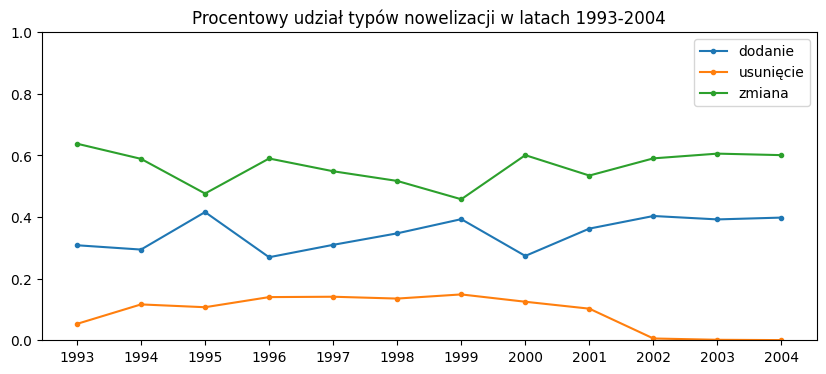

In [50]:
plt.figure(figsize=(10, 4))
plt.plot(years, additions, ".-", label="dodanie")
plt.plot(years, removals, ".-", label="usunięcie")
plt.plot(years, changes, ".-", label="zmiana")
plt.title("Procentowy udział typów nowelizacji w latach 1993-2004")
plt.xticks(years, years)
plt.ylim(0, 1)
plt.legend()
plt.show()

### 4. Policz liczbę wystąpień słowa ustawa w dowolnej formie fleksyjnej (ustawa, ustawie, itp.) i bez znaczenia na wielkość liter. Nie licz słów z tym samym prefiksem (np. ustawić).

Konstrukcja regexa:
- modyfikator case-insensitive,
- początek wyrazu,
- rdzeń "ustaw",
- jeden z możliwych przyrostków (lub jego brak),
- koniec wyrazu.

In [37]:
r4 = r"(?i)\bustaw(?:a|y|ie|ę|ą|o|om|ami|ach|)\b"

find_matches(pattern=r4, limit=1)

{'1993_599.txt': ['USTAWA',
  'ustawy',
  'ustawie',
  'ustawy',
  'ustawy',
  'ustawy',
  'ustawy',
  'ustawy',
  'ustawy',
  'ustawy',
  'ustawą',
  'Ustaw',
  'ustawy',
  'Ustawa',
  'ustawy']}

In [53]:
out4 = sum(count_matches(pattern=r4).values())
out4

24934

### 5. Jak wyżej, ale za którym występuje wyrażenie "z dnia".

In [54]:
r5 = r"(?i)\bustaw(?:a|y|ie|ę|ą|o|om|ami|ach|)\b z dnia"

out5 = sum(count_matches(pattern=r5).values())
out5

6935

### 6. Jak wyżej, ale za którym nie występuje wyrażenie "z dnia".

In [56]:
r6 = r"(?i)\bustaw(?:a|y|ie|ę|ą|o|om|ami|ach|)\b(?! z dnia)"

out6 = sum(count_matches(pattern=r6).values())
out6

17999

In [58]:
out4 == out5 + out6

True

### 7. Policz liczbę wystąpień słowa ustawa w dowolnej formie fleksyjnej, po którym nie występuje wyrażenie "o zmianie".

In [61]:
r7 = r"(?i)(?<!o zmianie )\bustaw(?:a|y|ie|ę|ą|o|om|ami|ach|)\b"

out7 = sum(count_matches(pattern=r7).values())
out7

24168

### 8. Przedstaw wyniki z punktów 4-7 na wykresie słupkowym.

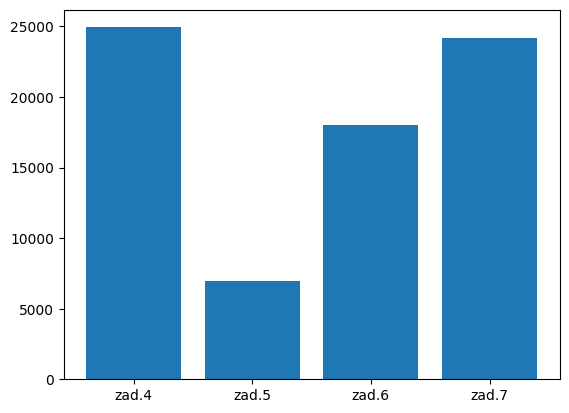

In [68]:
plt.bar(range(4), [out4, out5, out6, out7])
plt.xticks(range(4), [f"zad.{n}" for n in range(4, 8)])
plt.show()